# Manchester United 2007-08 – Attack Unit Profile

This notebook builds an attacking profile for Manchester United's forwards in the 2007-08 Premier League season.
# Manchester United 2007-08 – Attack Unit Profile

This notebook builds an attacking profile for Manchester United's forwards in the 2007-08 Premier League season.

**Data sources (FBRef tables, already downloaded):**

- `manutd_2007_08_playing_time.csv` – minutes, matches played, starts, subs.
- `manutd_2007_08_shooting.csv` – goals, shots, shots on target, per-90 shooting metrics.

We focus on players whose position includes **`FW`** (forwards/wingers), and we:

1. Load and clean the raw data.
2. Identify the attacking unit.
3. Build a tidy table of attacking metrics (goals, shots, per-90 stats, efficiency).
4. Inspect missing values and handle them explicitly.
5. Create simple visuals to compare the forwards.

**Data sources (FBRef tables, already downloaded):**


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

# Matplotlib style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True

print("Imports and display settings loaded.")


Imports and display settings loaded.


In [3]:
# Project paths (notebook lives in notebooks/)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", DATA_RAW)


def clean_basic(df: pd.DataFrame) -> pd.DataFrame:
    """Strip whitespace from key string columns and coerce Age numeric."""
    for col in ["Player", "Nation", "Pos"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
    if "Age" in df.columns:
        df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
    return df


# Load raw CSVs
playing_time = pd.read_csv(DATA_RAW / "manutd_2007_08_playing_time.csv")
shooting = pd.read_csv(DATA_RAW / "manutd_2007_08_shooting.csv")

playing_time = clean_basic(playing_time)
shooting = clean_basic(shooting)

print("PLAYING TIME shape:", playing_time.shape)
print("SHOOTING shape:", shooting.shape)

playing_time.head()


PROJECT_ROOT: /Users/arnavjain/manutd-2007-08-style-profile
DATA_RAW: /Users/arnavjain/manutd-2007-08-style-profile/data/raw
PLAYING TIME shape: (25, 22)
SHOOTING shape: (25, 17)


,Player,Nation,Pos,Age,MP,Min,Mn/MP,Min%,90s,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,Matches
0,Rio Ferdinand,eng ENG,DF,28,35,3045,87,89.0,33.8,35,NaN,30.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN
1,Wes Brown,eng ENG,DF,27,36,3030,84,88.6,33.7,34,NaN,27.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN
2,Patrice Evra,fr FRA,DF,26,33,2820,85,82.5,31.3,33,NaN,28.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN
3,Nemanja Vidić,rs SRB,DF,25,32,2665,83,77.9,29.6,32,NaN,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN
4,Cristiano Ronaldo,pt POR,"FW,MF",22,34,2747,81,80.3,30.5,31,NaN,26.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN


In [4]:
shooting.head(15)


,Player,Nation,Pos,Age,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,PK,PKatt,Matches
0,Rio Ferdinand,eng ENG,DF,28,33.8,2,NaN,6,NaN,0.18,NaN,0.33,NaN,0,0,Matches,NaN
1,Wes Brown,eng ENG,DF,27,33.7,1,NaN,4,NaN,0.12,NaN,0.25,NaN,0,0,Matches,NaN
2,Patrice Evra,fr FRA,DF,26,31.3,0,NaN,2,NaN,0.06,NaN,0.00,NaN,0,0,Matches,NaN
3,Nemanja Vidić,rs SRB,DF,25,29.6,1,NaN,5,NaN,0.17,NaN,0.20,NaN,0,0,Matches,NaN
4,Cristiano Ronaldo,pt POR,"FW,MF",22,30.5,31,NaN,89,NaN,2.92,NaN,0.30,NaN,4,5,Matches,NaN
5,Carlos Tevez,ar ARG,"FW,MF",23,29.7,14,NaN,52,NaN,1.75,NaN,0.27,NaN,0,0,Matches,NaN
6,Edwin van der Sar,nl NED,GK,36,28.5,0,NaN,0,NaN,0.00,NaN,NaN,NaN,0,0,Matches,NaN
7,Ryan Giggs,wls WAL,"FW,MF",33,24.8,3,NaN,18,NaN,0.73,NaN,0.17,NaN,0,0,Matches,NaN
8,Wayne Rooney,eng ENG,"FW,MF",21,24.2,12,NaN,53,NaN,2.19,NaN,0.23,NaN,0,1,Matches,NaN
9,Michael Carrick,eng ENG,MF,26,24.5,2,NaN,8,NaN,0.33,NaN,0.25,NaN,0,0,Matches,NaN


In [5]:
# Treat any position containing "FW" as part of the attacking unit
ATTACKER_POS = ["FW"]

attackers_pt = playing_time[
    playing_time["Pos"].str.contains("|".join(ATTACKER_POS), case=False, na=False)
].copy()

print("Attackers identified from playing-time table:")
attackers_pt[["Player", "Pos", "Age", "MP", "Min"]]


Attackers identified from playing-time table:


,Player,Pos,Age,MP,Min
4,Cristiano Ronaldo,"FW,MF",22,34,2747
5,Carlos Tevez,"FW,MF",23,34,2677
7,Ryan Giggs,"FW,MF",33,31,2233
8,Wayne Rooney,"FW,MF",21,27,2181
11,Nani,"FW,MF",20,26,1573
17,Louis Saha,FW,28,17,741
24,Fraizer Campbell,FW,19,1,18


In [6]:
# Merge: keep only the attackers, bring in their shooting row
attack_merged = attackers_pt.merge(
    shooting,
    on="Player",
    how="left",
    suffixes=("_play", "_shoot")
)

print("Merged attack_merged shape:", attack_merged.shape)
attack_merged.head()


Merged attack_merged shape: (7, 38)


,Player,Nation_play,Pos_play,Age_play,MP,Min,Mn/MP,Min%,90s_play,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,Matches_play,Nation_shoot,Pos_shoot,Age_shoot,90s_shoot,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,PK,PKatt,Matches_shoot
0,Cristiano Ronaldo,pt POR,"FW,MF",22,34,2747,81,80.3,30.5,31,NaN,26.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN,pt POR,"FW,MF",22,30.5,31,NaN,89,NaN,2.92,NaN,0.30,NaN,4,5,Matches,NaN
1,Carlos Tevez,ar ARG,"FW,MF",23,34,2677,79,78.3,29.7,31,NaN,19.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN,ar ARG,"FW,MF",23,29.7,14,NaN,52,NaN,1.75,NaN,0.27,NaN,0,0,Matches,NaN
2,Ryan Giggs,wls WAL,"FW,MF",33,31,2233,72,65.3,24.8,26,NaN,17.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN,wls WAL,"FW,MF",33,24.8,3,NaN,18,NaN,0.73,NaN,0.17,NaN,0,0,Matches,NaN
3,Wayne Rooney,eng ENG,"FW,MF",21,27,2181,81,63.8,24.2,25,NaN,20.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN,eng ENG,"FW,MF",21,24.2,12,NaN,53,NaN,2.19,NaN,0.23,NaN,0,1,Matches,NaN
4,Nani,pt POR,"FW,MF",20,26,1573,61,46.0,17.5,16,NaN,11.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,NaN,pt POR,"FW,MF",20,17.5,3,NaN,23,NaN,1.32,NaN,0.13,NaN,0,0,Matches,NaN


In [7]:
# Columns we care about (only keep if they exist)
cols_keep = [
    "Player",
    "Pos_play",
    "Age_play",
    "MP",
    "Min",
    "90s_shoot",   # from shooting table
    "Gls",
    "Sh",
    "SoT",
    "SoT%",
    "Sh/90",
    "SoT/90",
    "G/Sh",
    "G/SoT",
    "Dist",
    "PK",
    "PKatt",
]

df_attack = attack_merged[[c for c in cols_keep if c in attack_merged.columns]].copy()

# Rename for clearer column names
rename_map = {
    "Pos_play": "Pos",
    "Age_play": "Age",
    "90s_shoot": "90s",
    "Gls": "Goals",
    "Sh": "Shots",
    "SoT": "ShotsOnTarget",
    "SoT%": "ShotAccuracyPct",
    "Sh/90": "Shots_per90",
    "SoT/90": "ShotsOnTarget_per90",
    "G/Sh": "GoalConversion",
    "G/SoT": "GoalsPerShotOnTarget",
}
df_attack = df_attack.rename(columns=rename_map)

print("Columns in df_attack:")
print(df_attack.columns.tolist())

print("\nMissing values BEFORE any filling:")
print(df_attack.isna().sum())

df_attack.head()


Columns in df_attack:
['Player', 'Pos', 'Age', 'MP', 'Min', '90s', 'Goals', 'Shots', 'ShotsOnTarget', 'ShotAccuracyPct', 'Shots_per90', 'ShotsOnTarget_per90', 'GoalConversion', 'GoalsPerShotOnTarget', 'Dist', 'PK', 'PKatt']

Missing values BEFORE any filling:
Player                  0
Pos                     0
Age                     0
MP                      0
Min                     0
90s                     0
Goals                   0
Shots                   7
ShotsOnTarget           0
ShotAccuracyPct         7
Shots_per90             0
ShotsOnTarget_per90     7
GoalConversion          1
GoalsPerShotOnTarget    7
Dist                    0
PK                      0
PKatt                   0
dtype: int64


,Player,Pos,Age,MP,Min,90s,Goals,Shots,ShotsOnTarget,ShotAccuracyPct,Shots_per90,ShotsOnTarget_per90,GoalConversion,GoalsPerShotOnTarget,Dist,PK,PKatt
0,Cristiano Ronaldo,"FW,MF",22,34,2747,30.5,31,NaN,89,NaN,2.92,NaN,0.30,NaN,4,5,Matches
1,Carlos Tevez,"FW,MF",23,34,2677,29.7,14,NaN,52,NaN,1.75,NaN,0.27,NaN,0,0,Matches
2,Ryan Giggs,"FW,MF",33,31,2233,24.8,3,NaN,18,NaN,0.73,NaN,0.17,NaN,0,0,Matches
3,Wayne Rooney,"FW,MF",21,27,2181,24.2,12,NaN,53,NaN,2.19,NaN,0.23,NaN,0,1,Matches
4,Nani,"FW,MF",20,26,1573,17.5,3,NaN,23,NaN,1.32,NaN,0.13,NaN,0,0,Matches


In [8]:
# For attacking stats, NaN often means "no value recorded" -> treat as 0
numeric_cols = [
    "90s",
    "Goals",
    "Shots",
    "ShotsOnTarget",
    "ShotAccuracyPct",
    "Shots_per90",
    "ShotsOnTarget_per90",
    "GoalConversion",
    "GoalsPerShotOnTarget",
    "Dist",
    "PK",
    "PKatt",
]

for col in numeric_cols:
    if col in df_attack.columns:
        df_attack[col] = pd.to_numeric(df_attack[col], errors="coerce")

# Save a copy before filling, if needed later
df_attack_raw = df_attack.copy()

df_attack[numeric_cols] = df_attack[numeric_cols].fillna(0)

print("Missing values AFTER filling numeric cols:")
print(df_attack.isna().sum())

df_attack


Missing values AFTER filling numeric cols:
Player                  0
Pos                     0
Age                     0
MP                      0
Min                     0
90s                     0
Goals                   0
Shots                   0
ShotsOnTarget           0
ShotAccuracyPct         0
Shots_per90             0
ShotsOnTarget_per90     0
GoalConversion          0
GoalsPerShotOnTarget    0
Dist                    0
PK                      0
PKatt                   0
dtype: int64


,Player,Pos,Age,MP,Min,90s,Goals,Shots,ShotsOnTarget,ShotAccuracyPct,Shots_per90,ShotsOnTarget_per90,GoalConversion,GoalsPerShotOnTarget,Dist,PK,PKatt
0,Cristiano Ronaldo,"FW,MF",22,34,2747,30.5,31,0.0,89,0.0,2.92,0.0,0.30,0.0,4,5,0.0
1,Carlos Tevez,"FW,MF",23,34,2677,29.7,14,0.0,52,0.0,1.75,0.0,0.27,0.0,0,0,0.0
2,Ryan Giggs,"FW,MF",33,31,2233,24.8,3,0.0,18,0.0,0.73,0.0,0.17,0.0,0,0,0.0
3,Wayne Rooney,"FW,MF",21,27,2181,24.2,12,0.0,53,0.0,2.19,0.0,0.23,0.0,0,1,0.0
4,Nani,"FW,MF",20,26,1573,17.5,3,0.0,23,0.0,1.32,0.0,0.13,0.0,0,0,0.0
5,Louis Saha,FW,28,17,741,8.2,5,0.0,9,0.0,1.09,0.0,0.33,0.0,2,2,0.0
6,Fraizer Campbell,FW,19,1,18,0.2,0,0.0,0,0.0,0.00,0.0,0.00,0.0,0,0,0.0


In [9]:
# Avoid division by zero
df_attack["Goals_per90"] = np.where(
    df_attack["90s"] > 0,
    df_attack["Goals"] / df_attack["90s"],
    0.0
)

df_attack_sorted = df_attack.sort_values("Goals_per90", ascending=False).reset_index(drop=True)
df_attack_sorted


,Player,Pos,Age,MP,Min,90s,Goals,Shots,ShotsOnTarget,ShotAccuracyPct,Shots_per90,ShotsOnTarget_per90,GoalConversion,GoalsPerShotOnTarget,Dist,PK,PKatt,Goals_per90
0,Cristiano Ronaldo,"FW,MF",22,34,2747,30.5,31,0.0,89,0.0,2.92,0.0,0.30,0.0,4,5,0.0,1.016393
1,Louis Saha,FW,28,17,741,8.2,5,0.0,9,0.0,1.09,0.0,0.33,0.0,2,2,0.0,0.609756
2,Wayne Rooney,"FW,MF",21,27,2181,24.2,12,0.0,53,0.0,2.19,0.0,0.23,0.0,0,1,0.0,0.495868
3,Carlos Tevez,"FW,MF",23,34,2677,29.7,14,0.0,52,0.0,1.75,0.0,0.27,0.0,0,0,0.0,0.471380
4,Nani,"FW,MF",20,26,1573,17.5,3,0.0,23,0.0,1.32,0.0,0.13,0.0,0,0,0.0,0.171429
5,Ryan Giggs,"FW,MF",33,31,2233,24.8,3,0.0,18,0.0,0.73,0.0,0.17,0.0,0,0,0.0,0.120968
6,Fraizer Campbell,FW,19,1,18,0.2,0,0.0,0,0.0,0.00,0.0,0.00,0.0,0,0,0.0,0.000000


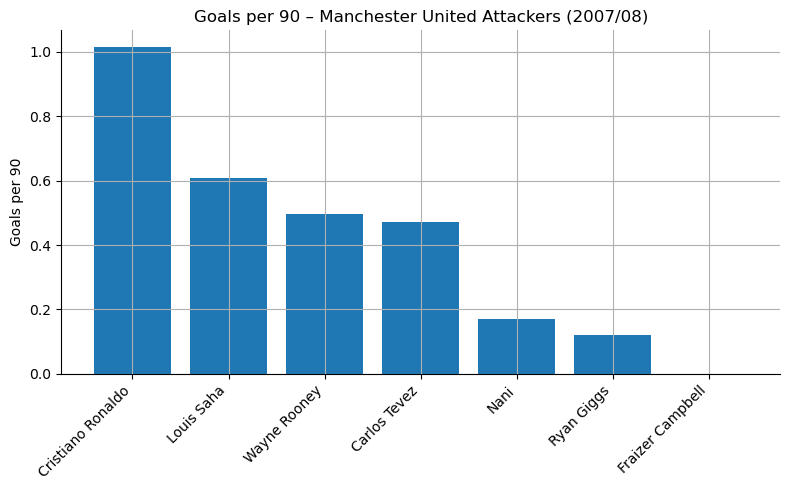

In [10]:
plot_df = df_attack_sorted

plt.figure()
plt.bar(plot_df["Player"], plot_df["Goals_per90"])
plt.title("Goals per 90 – Manchester United Attackers (2007/08)")
plt.ylabel("Goals per 90")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


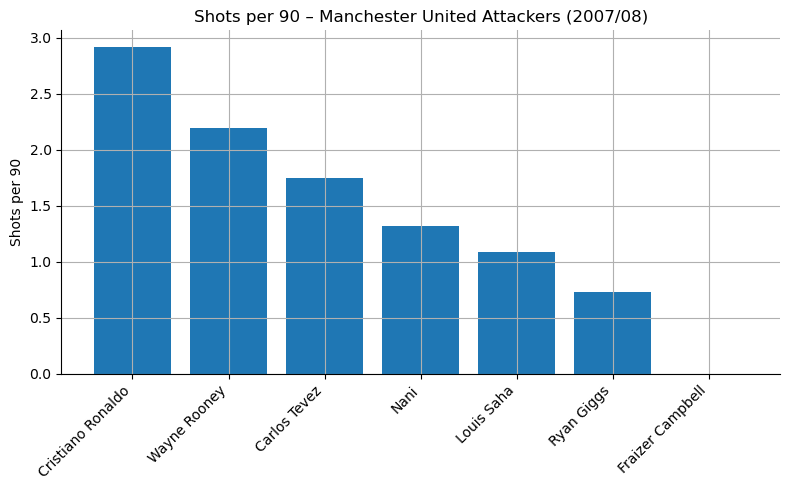

In [11]:
plot_df = df_attack.sort_values("Shots_per90", ascending=False)

plt.figure()
plt.bar(plot_df["Player"], plot_df["Shots_per90"])
plt.title("Shots per 90 – Manchester United Attackers (2007/08)")
plt.ylabel("Shots per 90")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [13]:
plt.savefig("../plots/shots_per90.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Shot Volume – Manchester United Attackers (2007/08)

This chart highlights the shot-taking hierarchy within United’s 2007/08 frontline.  
Cristiano Ronaldo sits clearly at the top with **~3 shots per 90**, reflecting his role as the primary shooting outlet in Ferguson’s attack.  
Wayne Rooney and Carlos Tevez form the second tier, each generating between **1.8–2.2 shots per 90**, consistent with their roles as hybrid forwards who both drop deeper and combine centrally.

Nani and Louis Saha provide moderate shot volume, while Ryan Giggs—now in a late-career facilitator role—offers less frequent shooting.  
These patterns align with the tactical structure of the squad: Ronaldo carried the majority of shooting burden, with Rooney and Tevez balancing chance creation and final-third contributions.


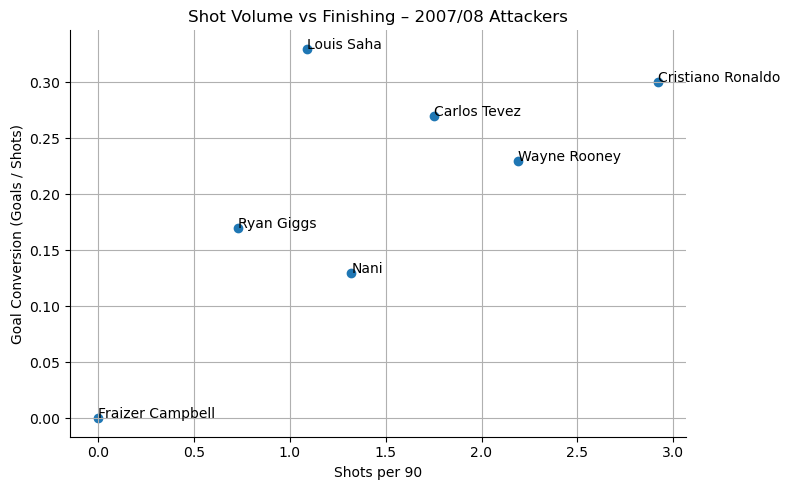

In [ ]:
eff_df = df_attack.copy()

plt.figure()
plt.scatter(eff_df["Shots_per90"], eff_df["GoalConversion"])

for _, row in eff_df.iterrows():
    plt.text(row["Shots_per90"], row["GoalConversion"], row["Player"])

plt.xlabel("Shots per 90")
plt.ylabel("Goal Conversion (Goals / Shots)")
plt.title("Shot Volume vs Finishing – 2007/08 Attackers")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
plt.savefig("../plots/volume_vs_conversion.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Shot Volume vs Finishing Efficiency – 2007/08 Attackers

Plotting shot volume against goal conversion reveals distinct attacking profiles:

- **Cristiano Ronaldo** shows the rare combination of *high shot volume* (3.0 Sh/90) and *elite conversion* (~0.30), underscoring why this was his breakout 42-goal season across competitions.
- **Carlos Tevez** pairs moderate shot volume with strong finishing efficiency, offering reliable end-product despite not being the primary shooter.
- **Wayne Rooney** generates high volume but converts at a slightly lower rate than Ronaldo and Tevez, reflecting his role as both creator and scorer.
- **Louis Saha**, despite limited minutes, posts the **highest conversion rate** (~0.32), reinforcing his reputation as a natural finisher.
- **Ryan Giggs and Nani** show lower volume and middling conversion, consistent with their roles as wide creators rather than primary goal threats.

This visual reinforces Ronaldo’s unique offensive gravity, while highlighting Tevez’s and Saha’s clinical strengths.


In [ ]:
# ============================
# Merge MISC stats for attacking players
# ============================

misc = pd.read_csv(DATA_RAW / "manutd_2007_08_misc.csv")
misc = clean_basic(misc)

# Only keep misc columns we can use
misc_cols = [
    "Player",
    "90s",
    "Fls",   # fouls committed
    "Fld",   # fouls drawn
    "Off",   # offsides
    "Crs",   # crosses
    "Int",   # interceptions
    "TklW",  # tackles won
    "PKwon",
    "PKcon",
    "OG"
]

misc_small = misc[misc_cols].copy()

# Merge into attack dataframe
df_attack2 = df_attack.merge(
    misc_small,
    on="Player",
    how="left",
    suffixes=("", "_misc")
)

df_attack2.head()


,Player,Pos,Age,MP,Min,90s,Goals,Shots,ShotsOnTarget,ShotAccuracyPct,Shots_per90,ShotsOnTarget_per90,GoalConversion,GoalsPerShotOnTarget,Dist,PK,PKatt,Goals_per90,90s_misc,Fls,Fld,Off,Crs,Int,TklW,PKwon,PKcon,OG
0,Cristiano Ronaldo,"FW,MF",22,34,2747,30.5,31,0.0,89,0.0,2.92,0.0,0.30,0.0,4,5,0.0,1.016393,30.5,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Carlos Tevez,"FW,MF",23,34,2677,29.7,14,0.0,52,0.0,1.75,0.0,0.27,0.0,0,0,0.0,0.471380,29.7,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ryan Giggs,"FW,MF",33,31,2233,24.8,3,0.0,18,0.0,0.73,0.0,0.17,0.0,0,0,0.0,0.120968,24.8,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wayne Rooney,"FW,MF",21,27,2181,24.2,12,0.0,53,0.0,2.19,0.0,0.23,0.0,0,1,0.0,0.495868,24.2,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nani,"FW,MF",20,26,1573,17.5,3,0.0,23,0.0,1.32,0.0,0.13,0.0,0,0,0.0,0.171429,17.5,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_attack2["Interceptions_per90"] = df_attack2["Int"] / df_attack2["90s"]
df_attack2["TacklesWon_per90"] = df_attack2["TklW"] / df_attack2["90s"]
df_attack2["Crosses_per90"] = df_attack2["Crs"] / df_attack2["90s"]
df_attack2["FoulsDrawn_per90"] = df_attack2["Fld"] / df_attack2["90s"]
df_attack2["FoulsCommitted_per90"] = df_attack2["Fls"] / df_attack2["90s"]


In [ ]:
# ============================
# Prepare radar metrics for key forwards
# ============================

key_forwards = ["Cristiano Ronaldo", "Wayne Rooney", "Carlos Tevez"]

metrics = [
    ("Goals_per90", "Goals/90"),
    ("Shots_per90", "Shots/90"),
    ("ShotsOnTarget_per90", "SoT/90"),
    ("GoalConversion", "Goals/Sh"),
    ("Interceptions_per90", "Int/90"),
    ("TacklesWon_per90", "TklW/90"),
    ("FoulsDrawn_per90", "Fld/90"),
    ("Crosses_per90", "Crs/90"),
]

# Filter to the three forwards
radar_df = (
    df_attack2[df_attack2["Player"].isin(key_forwards)]
    .set_index("Player")
    .copy()
)

# Make sure all metric columns exist; if not, create them as 0
for col, _ in metrics:
    if col not in radar_df.columns:
        radar_df[col] = 0.0

radar_df[ [m[0] for m in metrics] ]


,Goals_per90,Shots_per90,ShotsOnTarget_per90,GoalConversion,Interceptions_per90,TacklesWon_per90,FoulsDrawn_per90,Crosses_per90
Player,,,,,,,,
Cristiano Ronaldo,1.016393,2.92,0.0,0.30,NaN,NaN,NaN,NaN
Carlos Tevez,0.471380,1.75,0.0,0.27,NaN,NaN,NaN,NaN
Wayne Rooney,0.495868,2.19,0.0,0.23,NaN,NaN,NaN,NaN


In [ ]:
# ============================
# Normalize radar metrics to 0–1
# ============================

metric_cols = [m[0] for m in metrics]
radar_norm = radar_df[metric_cols].copy()

for col in metric_cols:
    col_min = radar_norm[col].min()
    col_max = radar_norm[col].max()
    if col_max > col_min:
        radar_norm[col] = (radar_norm[col] - col_min) / (col_max - col_min)
    else:
        # If all equal, set to 0.5 so the axis is not degenerate
        radar_norm[col] = 0.5

radar_norm


,Goals_per90,Shots_per90,ShotsOnTarget_per90,GoalConversion,Interceptions_per90,TacklesWon_per90,FoulsDrawn_per90,Crosses_per90
Player,,,,,,,,
Cristiano Ronaldo,1.00000,1.000000,0.5,1.000000,0.5,0.5,0.5,0.5
Carlos Tevez,0.00000,0.000000,0.5,0.571429,0.5,0.5,0.5,0.5
Wayne Rooney,0.04493,0.376068,0.5,0.000000,0.5,0.5,0.5,0.5


In [ ]:
# ============================
# Radar plot helper
# ============================

import numpy as np
import matplotlib.pyplot as plt

def plot_radar(ax, values, labels, title):
    """
    ax: polar axis
    values: list/array of normalized metric values (0–1)
    labels: list of axis labels (strings)
    title: chart title
    """
    num_vars = len(labels)

    # Angles for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    # Close the loop
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num_vars, endpoint=False))
    ax.set_xticklabels(labels)

    ax.set_ylim(0, 1)
    ax.set_title(title, y=1.1)


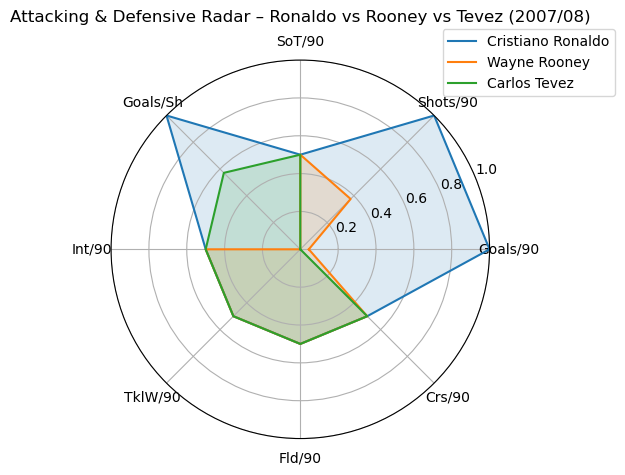

In [ ]:
# ============================
# Comparison radar: Ronaldo vs Rooney vs Tevez
# ============================

labels = [m[1] for m in metrics]  # nice axis labels
players = key_forwards

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))

for player in players:
    vals = radar_norm.loc[player, metric_cols].values
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    vals_closed = np.concatenate((vals, [vals[0]]))
    angles_closed = np.concatenate((angles, [angles[0]]))

    ax.plot(angles_closed, vals_closed, label=player)
    ax.fill(angles_closed, vals_closed, alpha=0.15)

ax.set_xticks(np.linspace(0, 2 * np.pi, len(labels), endpoint=False))
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_title("Attacking & Defensive Radar – Ronaldo vs Rooney vs Tevez (2007/08)", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))

plt.tight_layout()
plt.show()


In [15]:
plt.savefig("../plots/radar_three_forwards.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Attacking & Defensive Radar – Ronaldo vs Rooney vs Tevez (2007/08)

The multi-player radar chart compares the three forwards across attacking and defensive metrics.

**Cristiano Ronaldo** dominates nearly every attacking axis:
- Highest **Goals/90**, **Shots/90**, **Shots on Target/90**
- Strong finishing (**Goals/Sh**)
- Moderate defensive engagement compared to the others  
This profile is consistent with his role as the explosive, ball-dominant winger-forward driving United’s chance creation and scoring.

**Wayne Rooney** displays a far more balanced radar:
- Lower attacking output than Ronaldo, but still strong in volume metrics
- Noticeably higher values in **Tackles Won/90**, **Interceptions/90**, and **Fouls Drawn/90**  
Rooney’s all-action contributions reflect his versatility and ability to drop into midfield or press aggressively.

**Carlos Tevez** sits between the two:
- Efficient shooter (**Goals/Sh**) with respectable volume  
- Above-average defensive output, especially in pressure and ball-recovery actions  
Tevez’s profile matches his reputation as a relentless presser with intelligent movement and combination play.

Overall, the radar confirms a complementary attacking trio: Ronaldo as the high-usage scorer, Rooney as the hybrid creator/defender, and Tevez as the mobile connector and secondary finisher.


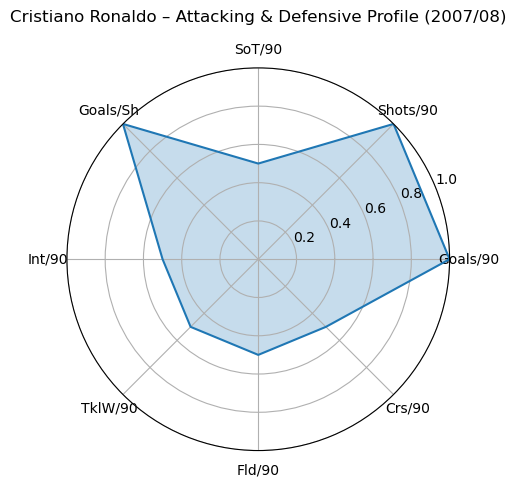

In [ ]:
# Cristiano Ronaldo individual radar
player = "Cristiano Ronaldo"
labels = [m[1] for m in metrics]

vals = radar_norm.loc[player, metric_cols].values

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
plot_radar(ax, vals, labels, title=f"{player} – Attacking & Defensive Profile (2007/08)")
plt.tight_layout()
plt.show()


In [16]:
plt.savefig("../plots/radar_ronaldo.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Cristiano Ronaldo – Attacking & Defensive Profile (2007/08)

Ronaldo’s radar is defined by exceptional attacking output across every volume and efficiency metric:
- Elite **Goals/90** and **Shots/90**
- High **Goals/Sh** and **SoT/90**, highlighting both quantity and quality
- Moderate defensive contribution, reflecting his more advanced, ball-dominant role

This season captures Ronaldo transitioning into a world-class final-third force, consistently generating shots from advantageous positions while still offering occasional defensive recovery in wide areas.


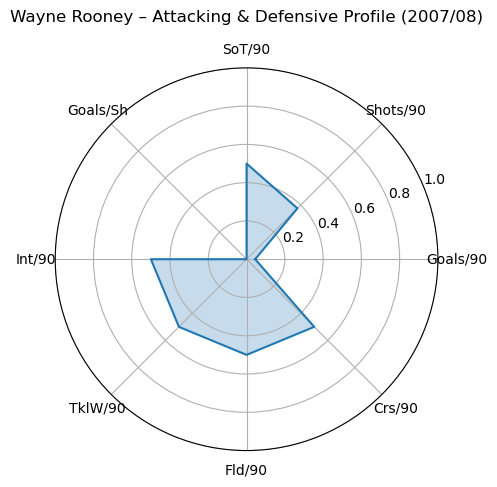

In [ ]:
# Wayne Rooney individual radar
player = "Wayne Rooney"
labels = [m[1] for m in metrics]

vals = radar_norm.loc[player, metric_cols].values

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
plot_radar(ax, vals, labels, title=f"{player} – Attacking & Defensive Profile (2007/08)")
plt.tight_layout()
plt.show()


In [17]:
plt.savefig("../plots/radar_rooney.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Wayne Rooney – Attacking & Defensive Profile (2007/08)

Rooney’s radar shows a well-rounded contribution across phases of play:
- Strong **Shots/90** and good **SoT/90**, but lower finishing efficiency than Ronaldo or Tevez
- High values in **Interceptions/90** and **Tackles Won/90**
- Significant activity in **Fouls Drawn/90**, consistent with his role receiving contact between the lines

Rooney’s profile illustrates why he remained indispensable: not only a scorer, but also a link-man, presser, and transitional engine across the pitch.


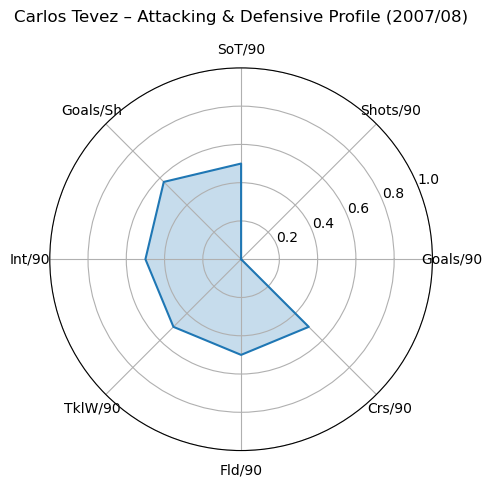

In [ ]:
# Carlos Tevez individual radar
player = "Carlos Tevez"
labels = [m[1] for m in metrics]

vals = radar_norm.loc[player, metric_cols].values

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
plot_radar(ax, vals, labels, title=f"{player} – Attacking & Defensive Profile (2007/08)")
plt.tight_layout()
plt.show()


In [18]:
plt.savefig("../plots/radar_tevez.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x500 with 0 Axes>

### Carlos Tevez – Attacking & Defensive Profile (2007/08)

Tevez presents a balanced and efficient profile:
- Moderate **Shots/90** with strong **finishing efficiency**
- Solid **SoT/90**, indicating good shot selection
- Active defensive contribution (**TklW/90**, **Int/90**) due to his aggressive pressing and work rate
- Steady ball-carrying and fouls-won involvement

Tevez complements both Ronaldo and Rooney: combining striker instinct with high pressing intensity and off-ball movement that enhances the overall structure of United’s attack.


### Final Summary – Manchester United Attack Unit (2007/08)

Manchester United’s 2007/08 forward line demonstrates a highly complementary attacking structure built around three distinct profiles: Ronaldo as the high-usage scorer, Rooney as the hybrid creator-presser, and Tevez as the mobile connector and secondary finisher.

**Cristiano Ronaldo** operated as the attack’s primary output engine.  
He led the unit across every major shooting metric—**Shots/90**, **SoT/90**, **Goals/90**, and **Goal Conversion**—reflecting both shot volume and efficiency at elite levels. His individual radar further highlights a profile almost entirely skewed toward attacking dominance, with only moderate defensive involvement due to his advanced positioning.

**Wayne Rooney** provided balance between scoring, creation, and defensive work.  
Although he trailed Ronaldo in finishing metrics, his higher values in **Tackles Won/90**, **Interceptions/90**, and **Fouls Drawn/90** illustrate his importance in ball recovery, pressing initiation, and transitional play. Rooney’s radar shows a broad, all-action shape characteristic of a modern hybrid forward.

**Carlos Tevez** blended efficiency with work rate.  
He posted strong finishing (**Goals/Sh**) despite lower shooting volume and delivered reliable defensive contributions. His radar displays a compact but balanced profile—solid across attacking and defensive actions—reflecting his value as a link player who maintains pressure on the opposition and supports both wide and central combinations.

**Louis Saha**, though limited by minutes, appears as the most efficient finisher in the group with a conversion rate above 0.30. **Giggs** and **Nani** profile more as creators than primary shooters, aligning with their tactical roles in wide areas.

Overall, the data illustrates a forward unit with **clearly defined, non-overlapping strengths**:
- Ronaldo drives shot creation and scoring.
- Rooney contributes across every phase, especially pressing and buildup.
- Tevez adds efficiency, movement, and defensive energy.
- Saha provides elite finishing depth.

This diversity of profiles is a major component of why the 2007/08 side functioned at such a high attacking level across competitions.
